In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler
import loompy as lp
import rpy2.rinterface_lib.callbacks
import logging
import scrublet as scr
from rpy2.robjects import pandas2ri
import anndata2ri
import scanorama

In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.5 umap==0.4.6 numpy==1.19.4 scipy==1.4.1 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.2


In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_header()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
scanpy==1.6.0 anndata==0.7.5 umap==0.4.6 numpy==1.19.4 scipy==1.4.1 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.2


In [4]:
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [5]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths("/home/spuccio/miniconda3/envs/singlecell/lib/R/library")

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)
library(clustree)
library(SingleCellExperiment)
library(CHETAH)
library(SingleR)
library(cowplot)
library(Matrix)

In [6]:
#adata = sc.read("/mnt/lugli/spuccio/SP028_Autoimmunity/h5_files/Desc_K10_cell.h5ad", cache=True)

In [7]:
adata = sc.read("/mnt/lugli/spuccio/SP028_Autoimmunity/h5_files/T_cells_Desc_K10_cell.h5ad", cache=False)

In [8]:
adata 

AnnData object with n_obs × n_vars = 52362 × 14494
    obs: 'CellId', 'CellFromTumor', 'PatientNumber', 'TumorType', 'TumorSite', 'CellType', 'dataset', 'desc_0.4', 'desc_0.5', 'desc_0.6', 'desc_0.7', 'desc_0.8', 'desc_0.9'
    var: 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'gene_id-2-0', 'gene_id-3-0', 'gene_id-4-0', 'gene_id-5-0', 'gene_id-6-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable_nbatches-0', 'highly_variable_intersection-0', 'gene_biotype', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'prob_matrix0.4', 'prob_matrix0.5', 'prob_matrix0.6', 'prob_matrix0.7', 'prob_matrix0.8', 'prob_matrix0.9'
    obsm: 'X_Embeded_z0.4', 'X_Embeded_z0.5', 'X_Embeded_z0.6', 'X_Embeded_z0.7', 'X_Embeded_z0.8', 'X_Embeded_z0.9'

### Start

In [9]:
data_clus = adata.obs[['desc_0.4','desc_0.5','desc_0.6','desc_0.7','desc_0.8','desc_0.9']]

In [10]:
#data_clus.columns

In [11]:
data_clus.columns = ['desc_r4_clusters', 'desc_r5_clusters','desc_r6_clusters', 'desc_r7_clusters', 'desc_r8_clusters','desc_r9_clusters']


In [12]:
data_clus.to_csv("/mnt/lugli/spuccio/SP028_Autoimmunity/h5_files/temp.csv",index=True,header=True)
data_clus2 = pd.read_csv("/mnt/lugli/spuccio/SP028_Autoimmunity/h5_files/temp.csv",index_col=0,header=0)

### Plot Clustree 

In [13]:
# these are the defaults we want to set:
default_units = 'in' # inch, to make it more easily comparable to matpplotlib
default_res = 100 # dpi, same as default in matplotlib
default_width = 10
default_height = 9
# try monkey-patching a function in rpy2, so we effectively get these
# default settings for the width, height, and units arguments of the %R magic command

old_setup_graphics = rpy2.ipython.rmagic.RMagics.setup_graphics

def new_setup_graphics(self, args):
    if getattr(args, 'units') is not None:
        if args.units != default_units: # a different units argument was passed, do not apply defaults
            return old_setup_graphics(self, args)
    args.units = default_units
    if getattr(args, 'res') is None:
        args.res = default_res
    if getattr(args, 'width') is None:
        args.width = default_width
    if getattr(args, 'height') is None:
        args.height = default_height        
    return old_setup_graphics(self, args)

rpy2.ipython.rmagic.RMagics.setup_graphics = new_setup_graphics

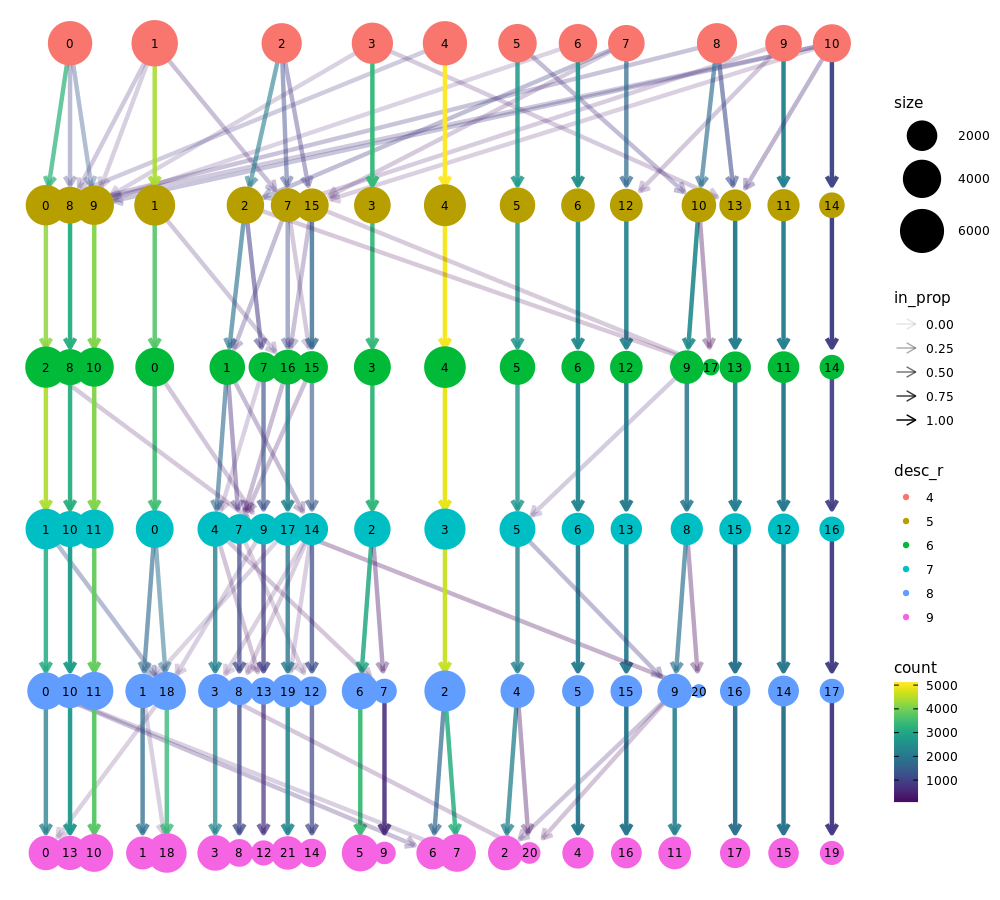

In [14]:
%%R -i data_clus2
library(clustree)

clustree(data_clus2,prefix="desc_r",suffix = "_clusters")

In [15]:
def run_vis(adata):
    if 'X_emb' in adata.obsm:
        sc.pp.neighbors(adata, use_rep='X_emb')
        sc.tl.umap(adata)
    else:
        sc.pp.pca(adata, svd_solver='arpack')
        sc.pp.neighbors(adata)
        sc.tl.umap(adata)

### UMAP 

In [16]:
adata.obsm['X_emb'] = adata.obsm['X_Embeded_z'+str(0.6)]
run_vis(adata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:17)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:02)


In [17]:
#sc.pp.log1p(adata)

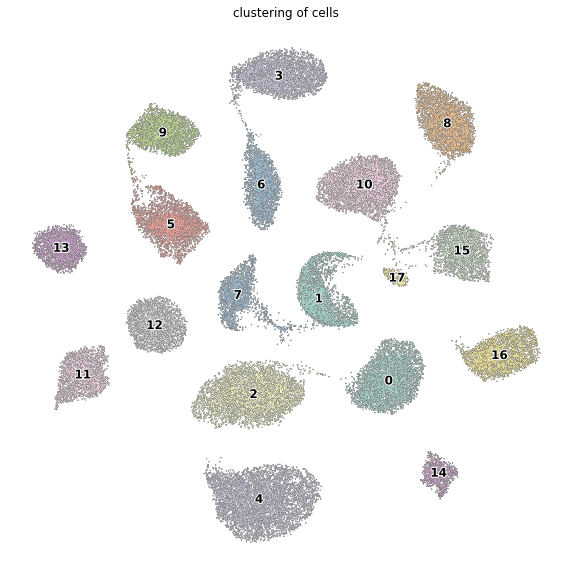

In [18]:
rcParams['figure.figsize'] = 10, 10
sc.pl.umap(adata, color=['desc_0.6'],color_map=mymap, add_outline=True,legend_loc='on data', 
           legend_fontsize=12, legend_fontoutline=2,frameon=False,
           title='clustering of cells', palette='Set3')

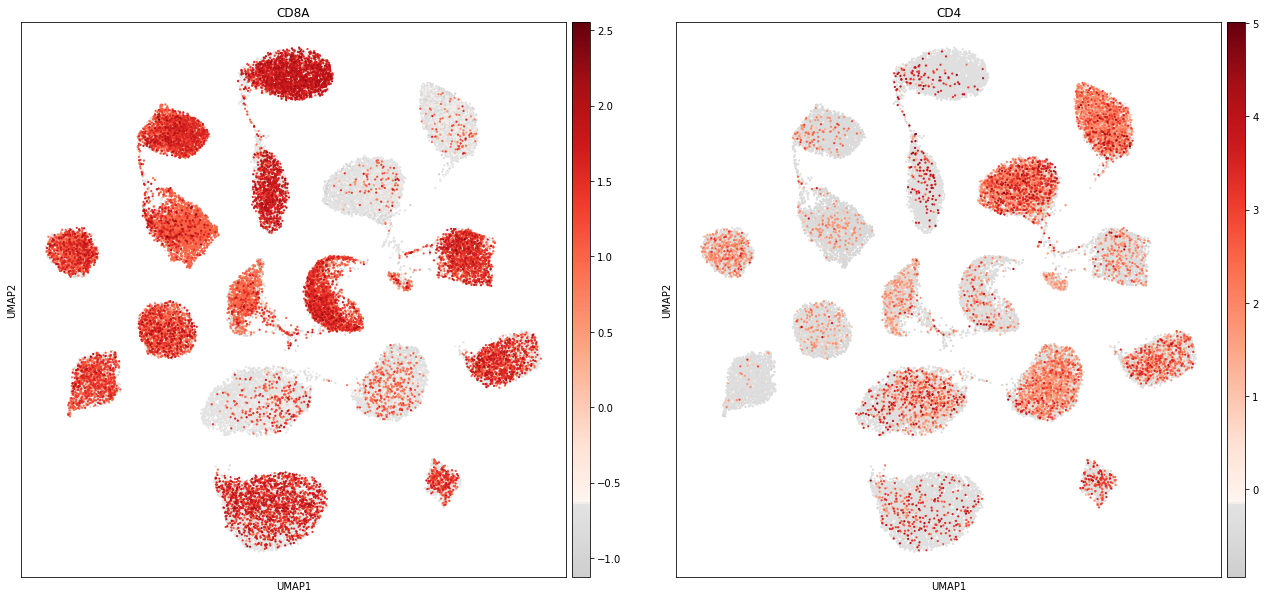

In [19]:
#adata.raw = adata
sc.pl.umap(adata, color=['CD8A','CD4'],color_map=mymap,legend_loc='on data',s=20,use_raw=False )

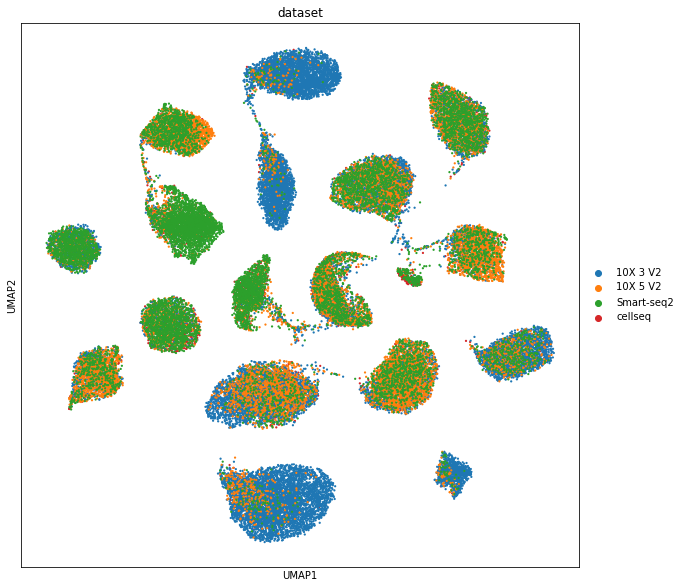

In [20]:
sc.pl.umap(adata, color=['dataset'],color_map=mymap,s=20,use_raw=True )

In [21]:
adata.obs.to_csv("/home/spuccio/isilon/spuccio/SP028_Autoimmunity/h5_files/temp.csv",sep="\t",header=True,index=True)

In [25]:
!cat <(head -1 /home/spuccio/isilon/spuccio/SP028_Autoimmunity/h5_files/temp.csv) <(awk 'BEGIN{FS=OFS="\t"}NR>1{if($5=="Skin_Mela") print $1,$2,$3,$5"_"$4,"Mela_"$6,$5,$7,$8,$9,$10,$11,$12,$13,$14;else print $1,$2,$3,$5"_"$4,$5,$6,$7,$8,$9,$10,$11,$12,$13,$1}' /home/spuccio/isilon/spuccio/SP028_Autoimmunity/h5_files/temp.csv) > /home/spuccio/isilon/spuccio/SP028_Autoimmunity/h5_files/temp2.csv 

In [26]:
adata.obs = pd.read_csv("/home/spuccio/isilon/spuccio/SP028_Autoimmunity/h5_files/temp2.csv",sep="\t",header=0,index_col=0)

In [27]:
adata.obs['PatientNumber'].unique()

array(['RA_Ptz301-0159', 'RA_Ptz301-0163', 'RA_Ptz301-0161',
       'RA_Ptz300-0511', 'RA_Ptz300-0486', 'RA_Ptz301-0122',
       'RA_Ptz301-0132', 'RA_Ptz300-0482', 'RA_Ptz300-0483',
       'RA_Ptz300-0485', 'RA_Ptz300-0481', 'RA_Ptz301-0250',
       'RA_Ptz300-0487', 'RA_Ptz300-0546', 'RA_Ptz300-0122',
       'RA_Ptz300-0211', 'RA_Ptz300-0213', 'RA_Ptz300-2590',
       'RA_Ptz300-0528', 'RA_Ptz300-0153', 'SLE_Ptz200-0109',
       'SLE_Ptz200-0871', 'SLE_Ptz200-0114', 'SLE_Ptz200-0872',
       'SLE_Ptz200-0115', 'SLE_Ptz200-0361', 'SLE_Ptz200-0362',
       'SLE_Ptz200-0961', 'SLE_Ptz200-0612', 'SLE_Ptz200-0107',
       'SLE_Ptz200-0391', 'SLE_Ptz200-0105', 'SLE_Ptz200-0341',
       'SLE_Ptz200-0040', 'SLE_Ptz200-0061', 'SLE_Ptz200-0062',
       'SLE_Ptz200-0339', 'SLE_Ptz200-0841', 'SLE_Ptz200-0874',
       'SLE_Ptz200-0108', 'SLE_Ptz200-0124', 'SLE_Ptz200-1216',
       'SLE_Ptz200-1217', 'SLE_Ptz200-0873', 'SLE_Ptz200-0875',
       'SLE_Ptz200-0127', 'IBD_Ptz6', 'IBD_Ptz7', 'IBD_Ptz8'

... storing 'CellFromTumor' as categorical
... storing 'PatientNumber' as categorical
... storing 'TumorType' as categorical
... storing 'TumorSite' as categorical
... storing 'CellType' as categorical
... storing 'dataset' as categorical
... storing 'desc_0.9' as categorical


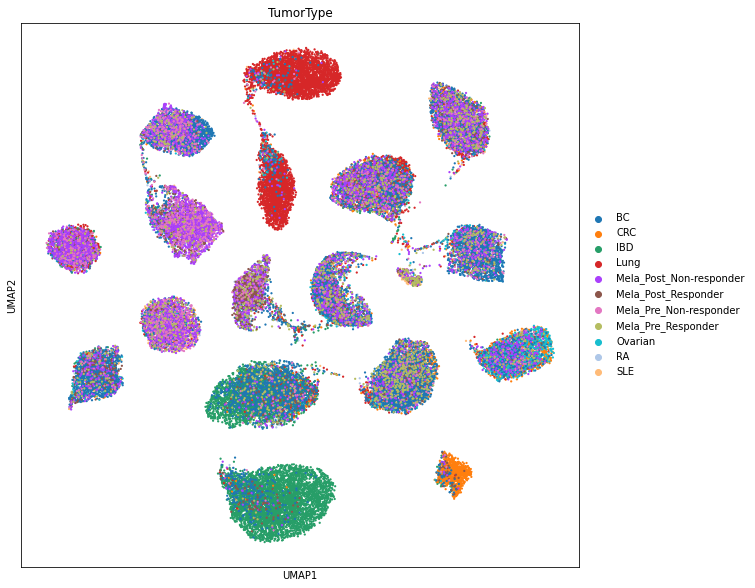

In [28]:
sc.pl.umap(adata, color=['TumorType'],color_map=mymap,s=20,use_raw=True )

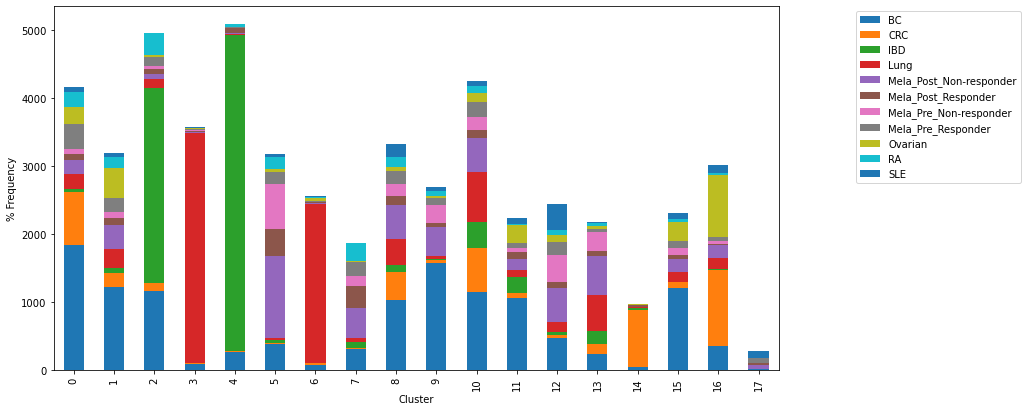

In [29]:
fig, (ax1) = plt.subplots(1,1, figsize=(33/2.54, 17/2.54))
ax1 = adata.obs.groupby("desc_0.6")["TumorType"].value_counts(normalize=False).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("% Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

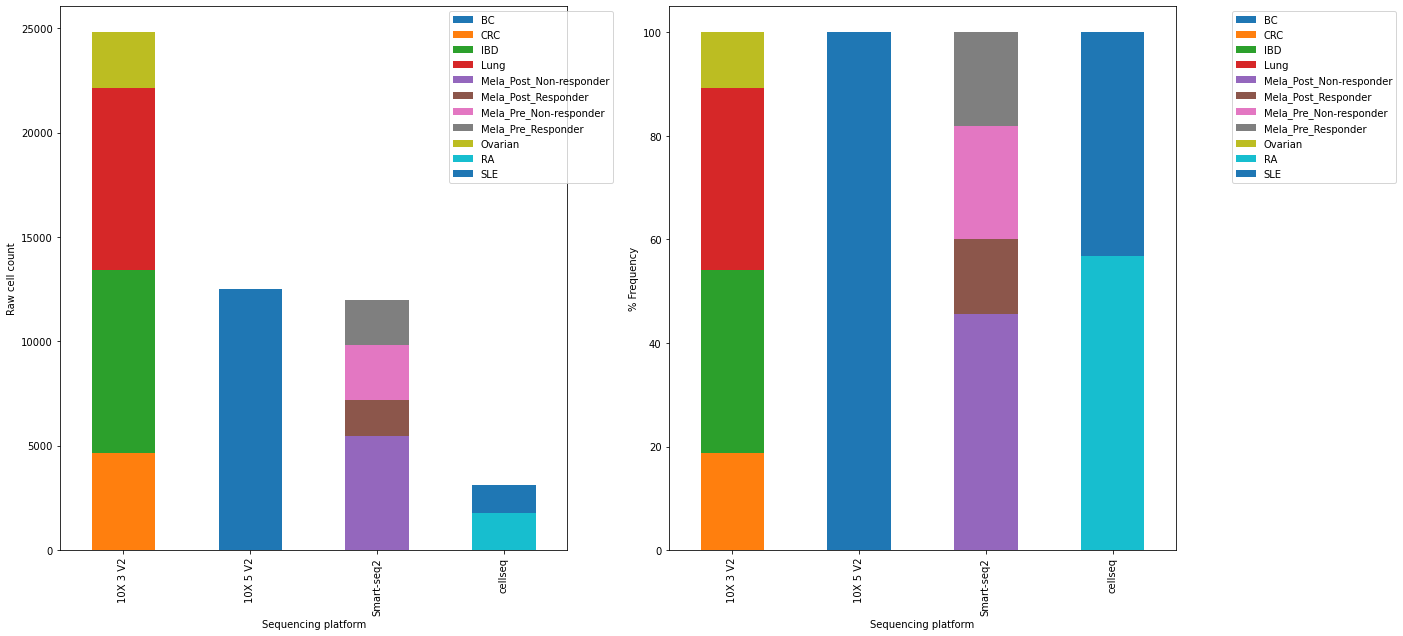

In [31]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
ax1 = pd.crosstab(adata.obs.dataset, adata.obs.TumorType).plot.bar(stacked=True,legend=False,ax=ax1)
ax1.set_xlabel("Sequencing platform")
ax1.set_ylabel("Raw cell count")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))
#
ax2 = (pd.crosstab(adata.obs.dataset, adata.obs.TumorType,normalize="index")*100).plot.bar(stacked=True,legend=False,ax=ax2)
ax2.set_xlabel("Sequencing platform")
ax2.set_ylabel("% Frequency")
ax2.grid(False)
ax2.legend(bbox_to_anchor=(1.1, 1.0))

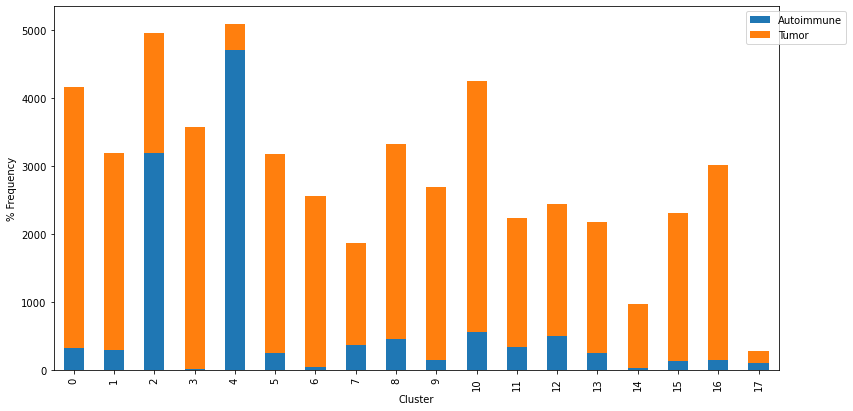

In [32]:
fig, (ax1) = plt.subplots(1,1, figsize=(33/2.54, 17/2.54))
ax1 = adata.obs.groupby("desc_0.6")["CellFromTumor"].value_counts(normalize=False).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("% Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

In [33]:
!cat <(head -1 /home/spuccio/isilon/spuccio/SP028_Autoimmunity/h5_files/temp2.csv) <(awk 'BEGIN{FS=OFS="\t"}NR>1{print $1,$2,$3,$4,$3"_"$5,$6,$7,$8,$9,$10,$11,$12,$13,$1}' /home/spuccio/isilon/spuccio/SP028_Autoimmunity/h5_files/temp2.csv) > /home/spuccio/isilon/spuccio/SP028_Autoimmunity/h5_files/temp3.csv

In [34]:
adata.obs = pd.read_csv("/home/spuccio/isilon/spuccio/SP028_Autoimmunity/h5_files/temp3.csv",sep="\t",header=0,index_col=0)

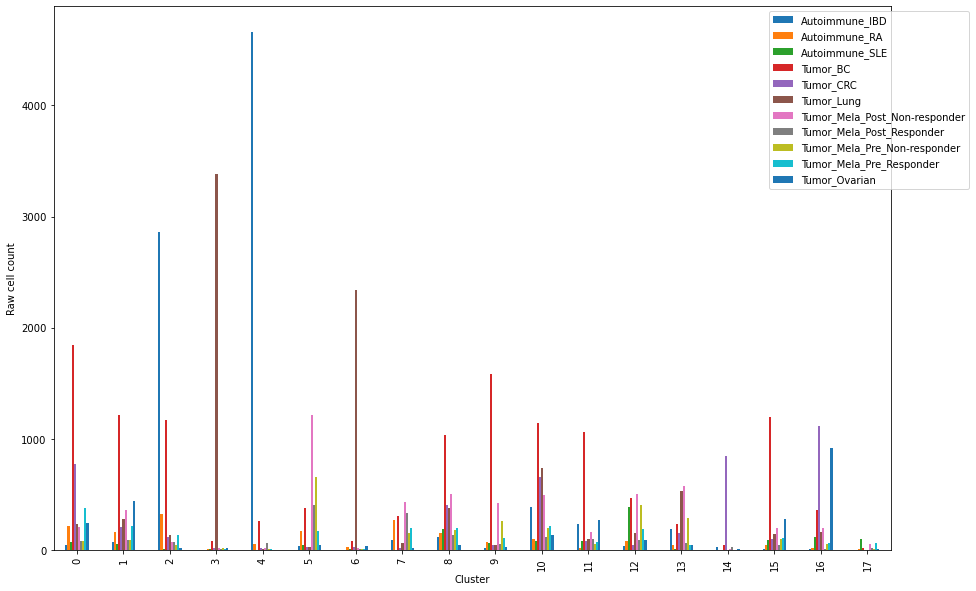

In [35]:
fig, (ax1) = plt.subplots(1,1, figsize=(15,10))
#
ax1 = pd.crosstab(adata.obs["desc_0.6"], adata.obs.TumorType).plot.bar(stacked=False,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Raw cell count")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

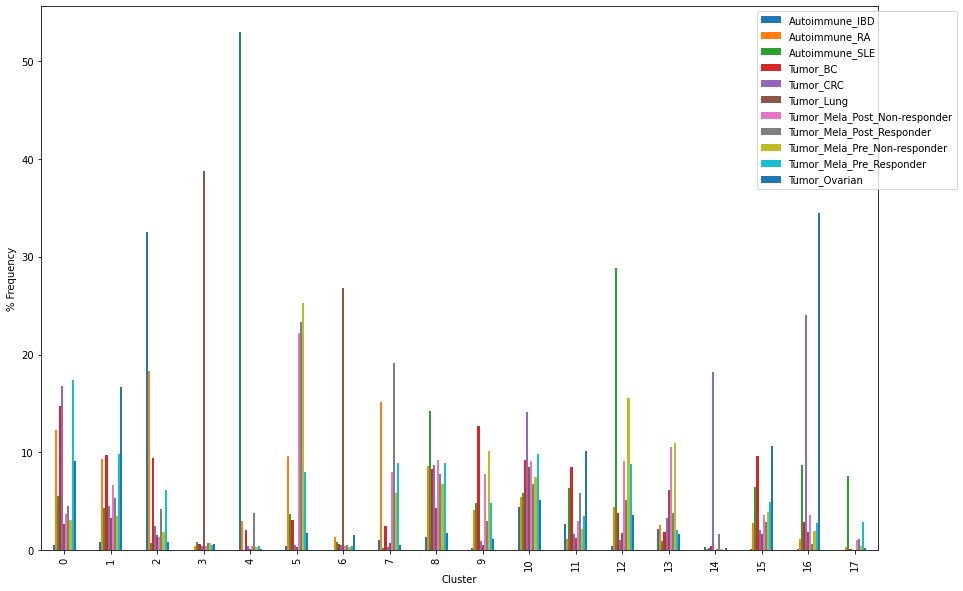

In [36]:
fig, (ax1) = plt.subplots(1,1, figsize=(15,10))
#
ax1 = (pd.crosstab(adata.obs["desc_0.6"], adata.obs.TumorType,normalize="columns")*100).plot.bar(stacked=False,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("% Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

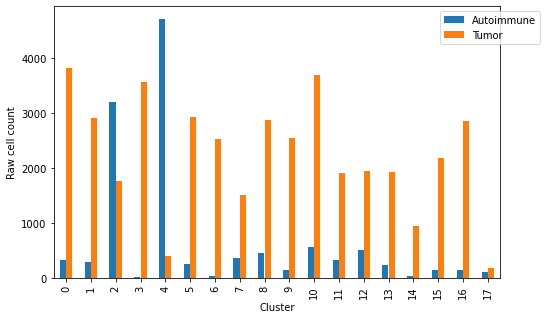

In [37]:
fig, (ax1) = plt.subplots(1,1, figsize=(8,5))
#
ax1 = (pd.crosstab(adata.obs["desc_0.6"], adata.obs.CellFromTumor,normalize=False)).plot.bar(stacked=False,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Raw cell count")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

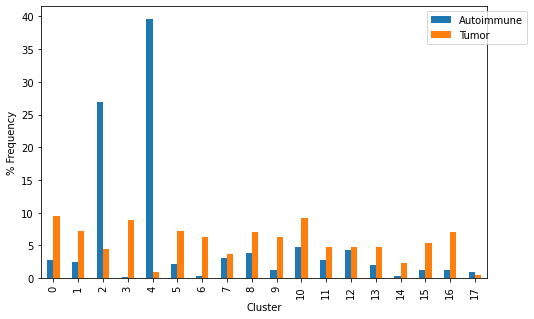

In [38]:
fig, (ax1) = plt.subplots(1,1, figsize=(8,5))
#
ax1 = (pd.crosstab(adata.obs["desc_0.6"], adata.obs.CellFromTumor,normalize='columns')*100).plot.bar(stacked=False,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("% Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

### Plot phenotype marker

In [47]:
# fix dtype 
col_names = list(adata.obs)
for col in col_names:
    adata.obs[col] = adata.obs[col].astype('category',copy=False)
#print(adata.obs.dtypes)

CellId           category
CellFromTumor    category
PatientNumber    category
TumorType        category
TumorSite        category
CellType         category
dataset          category
desc_0.4         category
desc_0.5         category
desc_0.6         category
desc_0.7         category
desc_0.8         category
desc_0.9         category
dtype: object


In [48]:
sc.tl.dendrogram(adata,groupby="desc_0.6")

         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:40)
Storing dendrogram info using `.uns["dendrogram_['desc_0.6']"]`


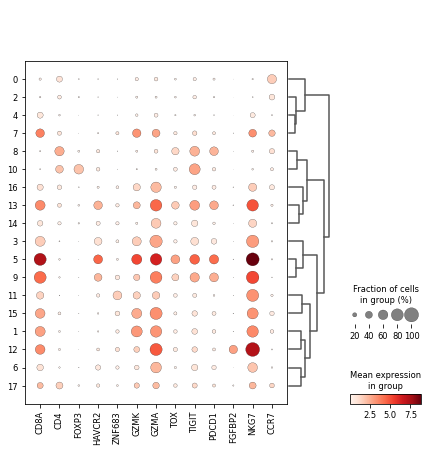

In [49]:
rcParams['figure.figsize'] = 10,10
sc.pl.dotplot(adata, ['CD8A','CD4','FOXP3','HAVCR2','ZNF683','GZMK','GZMA','TOX','TIGIT','PDCD1','FGFBP2','NKG7','CCR7'], 'desc_0.6', dendrogram=True)

### Cluster DEGS

In [50]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [51]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [52]:
adata.var['rb'] = adata.var_names.str.startswith('RP')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['rb'], percent_top=None, log1p=False, inplace=True)

In [53]:
mito_gene_names = sc.queries.mitochondrial_genes("hsapiens")

In [54]:
mito_gene_indicator = np.in1d(adata.var_names, mito_gene_names)

In [55]:
#print(adata.n_obs, adata.n_vars)
malat1 = adata.var_names.str.startswith('MALAT1')
#protein_genes= adata_bc_Tcell.var.gene_biotype.str.startswith('protein_coding')
ribo_genes = adata.var_names.str.startswith(("RPS","RPL"))
remove = np.add(ribo_genes, malat1)
keep = np.invert(remove)

adata = adata[:,keep]

#print(adata.n_obs, adata.n_vars)

In [56]:
adata = adata[:, ~mito_gene_indicator]

In [57]:
adata.obsm["raw_layer"] = adata.raw

In [58]:
adata.raw = adata

In [59]:
sc.tl.rank_genes_groups(adata, 'desc_0.6', method='wilcoxon',use_raw=True,pts=False)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:02:26)


/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:407: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,TPT1,GZMK,TPT1,NKG7,TNFAIP3,CLDN23,HSPA1A,CLDN23,NR3C1,OVOL2,FOXP3,XCL1,NKG7,STMN1,FAM118A,GZMA,VIM,FOLR2
1,LTB,CCL5,EEF1A1,HLA-A,TPT1,STEAP1,NDNF,STEAP1,CXCL13,PPP1R14C,IL32,TYROBP,GZMH,TUBB,RAB11FIP1,CCL5,EEF1A1,EHF
2,EEF1A1,CST7,EEF1B2,HLA-B,EEF1A1,CHMP4C,SPOCK3,CHMP4C,CD4,PKP2,BATF,KLRD1,HBA2,TUBA1B,CSF1,C21orf62,PPIA,RAB42
3,IL7R,CCL4,PTMA,LY6E,IL7R,TMEM125,GSDMC,TMEM125,ICA1,NPPC,LTB,FCER1G,LYPD6B,HMGB2,CAMK2N1,LYPD1,S100A11,S100A9
4,PABPC1,GZMA,EEF1D,CCL5,ZFP36L2,PPP1R14A,HEYL,RHOV,TNFRSF4,HOXB5,CTLA4,CD7,C9orf116,TYMS,NTRK2,OTUD6A,S100A6,INHBB
5,EEF1B2,NKG7,PABPC1,GZMA,NFKBIA,RHOV,PDZRN3,PPP1R14A,FKBP5,L1TD1,TNFRSF18,KLRC1,TMEM52,MKI67,NAALAD2,TNNI3,ANXA2,PSCA
6,EEF2,CD8A,NACA,ISG15,AGTR1,NMU,CYP4X1,SHROOM1,SRGN,CLDN16,TNFRSF4,CTSW,RAB42,NUSAP1,ZFHX3,PLA2G7,PFN1,ARHGEF25
7,LDHB,LAMC2,CCR7,LAG3,CAPN11,LAD1,CAP2,TSPAN6,TNFRSF18,C2CD4A,IL2RA,GNLY,VWA1,DUT,ZNF703,HES2,GIMAP4,COX4I2
8,CCR7,SST,UBA52,IFI44L,C8orf48,SOX9,CASQ1,LAD1,CORO1B,HOXB9,TIGIT,AREG,CPA3,ACTB,HOXB3,RNF128,DPP4,CLGN
9,TCF7,F3,AP3M2,MX1,PRDM12,TUSC3,KHDRBS2,NMU,ITM2A,EPHB3,SAT1,KLRC2,SYCE3,TMPO,ZNRF3,TNNC1,AQP3,LURAP1L


### Correlation between clusters

In [60]:
sc.tl.dendrogram(adata, 'desc_0.6')

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns["dendrogram_['desc_0.6']"]`


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_desc_0.6']`


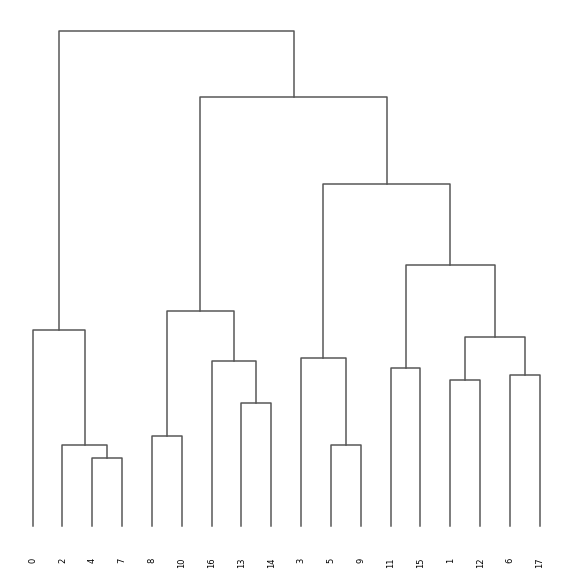

In [61]:
ax = sc.pl.dendrogram(adata, 'desc_0.6')

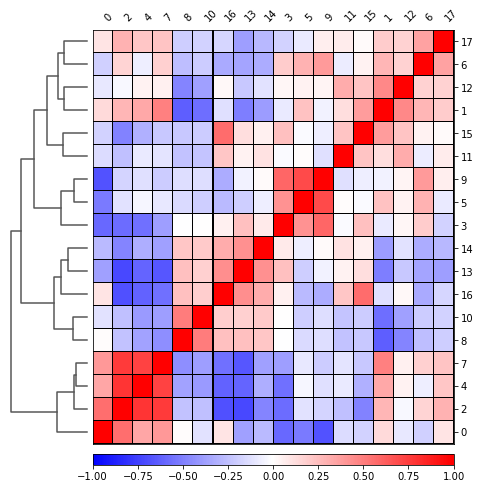

In [62]:
ax = sc.pl.correlation_matrix(adata, 'desc_0.6', figsize=(8,8))

In [63]:
result = adata.uns['rank_genes_groups']

In [ ]:
#result

In [64]:
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:]: result[key][group]
    for group in groups for key in ['names','pvals','pvals_adj','logfoldchanges']}).to_csv("/mnt/lugli/spuccio/SP028_Autoimmunity/h5_files/Data_integrated_Res06_3.csv",header=True,index=False)

### Dataset Freq

In [65]:
pd.crosstab(adata.obs.dataset, adata.obs.TumorType).to_csv("/home/spuccio/isilon/spuccio/SP028_Autoimmunity/h5_files/Raw_num_cell_versus_dataset_3.csv",sep="\t",header=True,index=True)

In [66]:
(pd.crosstab(adata.obs.dataset, adata.obs.TumorType,normalize="index")*100).to_csv("/home/spuccio/isilon/spuccio/SP028_Autoimmunity/h5_files/Norm_num_cell_versus_dataset_3.csv",sep="\t",header=True,index=True)

### TumorType

In [67]:
pd.crosstab(adata.obs["desc_0.6"], adata.obs.TumorType).to_csv("/home/spuccio/isilon/spuccio/SP028_Autoimmunity/h5_files/Raw_ClusterRes6_along_TumortType_3.csv",sep="\t",header=True,index=True)

In [68]:
(pd.crosstab(adata.obs["desc_0.6"], adata.obs.TumorType,normalize="index")*100).to_csv("/home/spuccio/isilon/spuccio/SP028_Autoimmunity/h5_files/Norm_index_ClusterRes6_along_TumortType_3.csv",sep="\t",header=True,index=True)

In [69]:
(pd.crosstab(adata.obs["desc_0.6"], adata.obs.TumorType,normalize=False)*100).to_csv("/home/spuccio/isilon/spuccio/SP028_Autoimmunity/h5_files/Raw_ClusterRes6_along_TumortType_3.csv",sep="\t",header=True,index=True)

### Dataset Type

In [72]:
(pd.crosstab(adata.obs["desc_0.6"], adata.obs.CellFromTumor,normalize=False)).to_csv("/home/spuccio/isilon/spuccio/SP028_Autoimmunity/h5_files/Raw_ClusterRes6_along_CellFromTumor_3.csv",sep="\t",header=True,index=True)

In [73]:
(pd.crosstab(adata.obs["desc_0.6"], adata.obs.CellFromTumor,normalize='columns')*100).to_csv("/home/spuccio/isilon/spuccio/SP028_Autoimmunity/h5_files/Norm_Col_ClusterRes6_along_CellFromTumor_3.csv",sep="\t",header=True,index=True)

In [74]:
(pd.crosstab(adata.obs["desc_0.6"], adata.obs.CellFromTumor,normalize='index')*100).to_csv("/home/spuccio/isilon/spuccio/SP028_Autoimmunity/h5_files/Norm_index_ClusterRes6_along_CellFromTumor_3.csv",sep="\t",header=True,index=True)

## PTZ

In [75]:
pd.crosstab(adata.obs["desc_0.6"], adata.obs.PatientNumber,normalize=False).to_csv("/home/spuccio/isilon/spuccio/SP028_Autoimmunity/h5_files/Raw_ClusterRes6_along_PatientNumber_3.csv",sep="\t",header=True,index=True)

In [76]:
(pd.crosstab(adata.obs["desc_0.6"], adata.obs.PatientNumber,normalize="columns")*100).to_csv("/home/spuccio/isilon/spuccio/SP028_Autoimmunity/h5_files/Norm_ClusterRes6_along_PatientNumber_3.csv",sep="\t",header=True,index=True)

In [77]:
(pd.crosstab(adata.obs["desc_0.6"], adata.obs.PatientNumber,normalize="index")*100).to_csv("/home/spuccio/isilon/spuccio/SP028_Autoimmunity/h5_files/Norm_Index_ClusterRes6_along_PatientNumber_3.csv",sep="\t",header=True,index=True)

In [78]:
adata.write("/home/spuccio/isilon/spuccio/SP028_Autoimmunity/h5_files/integrated_second_3.h5ad")